# Time Series clustering with CNN autoencoders

![](https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-4.png)

In [2]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook is an attempt to use a new methodology for clustering time series using ``autoencoders``. <br>
I will use Financial stock price data as test data for their easy accessibility. 


## Preparing the data

### Connecting with ``AlphaVantage`` API

Data available via the API https://www.alphavantage.co/

#### Retrieve API KEY

In [3]:
import json
API_KEY = json.loads(open("c:/data/tokens.json").read())["ALPHA_VANTAGE"]

#### Prepare a wrapper for the API

In [8]:
import requests

In [9]:
class AlphaVantage(object):
    def __init__(self,api_key = API_KEY):
        self.api_key = api_key
        
    def get(self,symbol):
        data = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey={}".format(symbol,self.api_key)).json()
        data = pd.DataFrame(data["Time Series (Daily)"]).astype(float).transpose()
        data.columns = ["open","high","low","close","volume"]
        data.index = pd.to_datetime(data.index)
        return data

In [10]:
alpha = AlphaVantage()

In [11]:
aapl = alpha.get("AAPL")

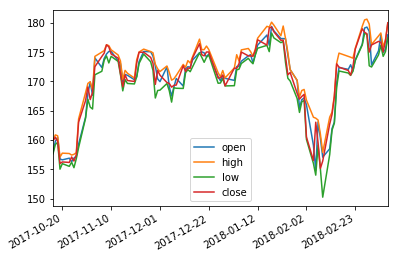

In [12]:
aapl.drop("volume",axis = 1).plot()
plt.show()

### Creating some wrappers

#### Prepare a wrapper for the companies data

We will use ``cufflinks`` for easy plotting : http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html

In [13]:
import plotly.graph_objs as go
from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected = True)
import cufflinks as cf

In [14]:
class Company(object):
    def __init__(self,symbol):
        self.symbol = symbol
        self.data = alpha.get(symbol)
        
    def __repr__(self):
        return self.symbol
    
    def plot(self,variable = "close"):
        if type(variable) != list: variable = [variable]
        fig = self.data[variable].iplot(world_readable=True,asFigure=True)
        iplot(fig)

In [15]:
aapl = Company("AAPL")

In [16]:
aapl.plot(["open","close"])

#### Prepare a wrapper for Companies

In [40]:
import time

class Companies(object):
    def __init__(self,symbols = None,companies = None,data = None):
        if companies is not None:
            self.data = companies
        elif symbols is not None:
            self.data = []
            for symbol in tqdm(symbols,desc = "Acquiring data"):
                try:
                    company = Company(symbol)
                    self.data.append(company)
                    if len(symbols) > 20:
                        time.sleep(1)
                except Exception as e:
                    print("- Skipped company {}".format(symbol))
            
    def __repr__(self):
        return "{} companies in the dataset".format(len(self))
    
    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        return iter(self.data)
    
    def __getitem__(self,key):
        if type(key) != list : key = [key]
        return [company for company in self if company.symbol in key]
    
    
    def get_data(self,symbols = None,variable = "close",normalization = True):
        if symbols is not None:
            companies = self[symbols]
        else:
            companies = self.data       
        data = pd.concat([company.data[[variable]].rename(columns = {variable:company.symbol}) for company in self],axis = 1)
        
        if normalization:
            data /= data.max(axis = 0)
            
        return data
    
    
    def plot(self,symbols = None,variable = "close"):
        data = self.get_data(symbols,variable)
        fig = data.iplot(world_readable=True,asFigure=True)
        iplot(fig)

In [41]:
c = Companies(["AAPL","GOOG","MSFT"])

Acquiring data: 100%|████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


In [19]:
c.plot()

### Extracting data for a given list of companies

#### Finding a list of symbols

The simplest way to gather a list of tickers on the web is simply using wikipedia. <br>
I will scrape the data in the page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies to constitute the list

In [20]:
import requests
import bs4 as bs

In [21]:
page = bs.BeautifulSoup(requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").content,"lxml")

In [22]:
rows = page.find("div",class_ = "mw-parser-output").find("table").findAll("tr")
tickers = pd.DataFrame([{"ticker":row.find("a").text,"link":row.find("a").attrs["href"]} for row in rows],columns = ["ticker","link"])
tickers = tickers.iloc[1:].reset_index(drop = True)

#### Extracting data for the list of symbols

In [ ]:
sp = Companies(symbols = list(tickers.ticker))

Acquiring data:   8%|█▉                       | 38/505 [01:04<13:11,  1.70s/it]

- Skipped company ABC


Acquiring data:   8%|█▉                       | 39/505 [01:04<12:55,  1.66s/it]

- Skipped company AME


Acquiring data:   8%|█▉                       | 40/505 [01:05<12:40,  1.64s/it]

- Skipped company AMGN


Acquiring data:   8%|██                       | 41/505 [01:05<12:25,  1.61s/it]

- Skipped company APH


Acquiring data:   8%|██                       | 42/505 [01:06<12:11,  1.58s/it]

- Skipped company APC


Acquiring data:   9%|██▏                      | 43/505 [01:06<11:58,  1.55s/it]

- Skipped company ADI


Acquiring data:   9%|██▏                      | 44/505 [01:07<11:45,  1.53s/it]

- Skipped company ANDV


Acquiring data:   9%|██▏                      | 45/505 [01:07<11:33,  1.51s/it]

- Skipped company ANSS


Acquiring data:   9%|██▎                      | 46/505 [01:08<11:21,  1.49s/it]

- Skipped company ANTM


Acquiring data:   9%|██▎                      | 47/505 [01:08<11:10,  1.46s/it]

- Skipped company AON


Acquiring data:  10%|██▍                      | 48/505 [01:09<10:59,  1.44s/it]

- Skipped company AOS


Acquiring data:  10%|██▍                      | 49/505 [01:09<10:49,  1.42s/it]

- Skipped company APA


Acquiring data:  10%|██▍                      | 50/505 [01:10<10:39,  1.41s/it]

- Skipped company AIV


Acquiring data:  10%|██▌                      | 51/505 [01:10<10:29,  1.39s/it]

- Skipped company AAPL


Acquiring data:  10%|██▌                      | 52/505 [01:11<10:20,  1.37s/it]

- Skipped company AMAT


Acquiring data:  17%|████▏                    | 84/505 [02:03<10:17,  1.47s/it]

- Skipped company BF.B


Acquiring data:  17%|████▏                    | 85/505 [02:03<10:10,  1.45s/it]

- Skipped company CHRW


Acquiring data:  17%|████▎                    | 86/505 [02:04<10:04,  1.44s/it]

- Skipped company CA


Acquiring data:  17%|████▎                    | 87/505 [02:04<09:58,  1.43s/it]

- Skipped company COG


Acquiring data:  17%|████▎                    | 88/505 [02:05<09:53,  1.42s/it]

- Skipped company CDNS


Acquiring data:  18%|████▍                    | 89/505 [02:05<09:47,  1.41s/it]

- Skipped company CPB


Acquiring data:  18%|████▍                    | 90/505 [02:06<09:41,  1.40s/it]

- Skipped company COF


Acquiring data:  18%|████▌                    | 91/505 [02:06<09:36,  1.39s/it]

- Skipped company CAH


Acquiring data:  18%|████▌                    | 92/505 [02:07<09:30,  1.38s/it]

- Skipped company CBOE


Acquiring data:  18%|████▌                    | 93/505 [02:07<09:25,  1.37s/it]

- Skipped company KMX


Acquiring data:  19%|████▋                    | 94/505 [02:08<09:20,  1.36s/it]

- Skipped company CCL


Acquiring data:  19%|████▋                    | 95/505 [02:08<09:15,  1.35s/it]

- Skipped company CAT


Acquiring data:  19%|████▊                    | 96/505 [02:09<09:10,  1.35s/it]

- Skipped company CBG


Acquiring data:  19%|████▊                    | 97/505 [02:09<09:05,  1.34s/it]

- Skipped company CBS


Acquiring data:  19%|████▊                    | 98/505 [02:10<09:00,  1.33s/it]

- Skipped company CELG


Acquiring data:  20%|████▉                    | 99/505 [02:10<08:55,  1.32s/it]

- Skipped company CNC


Acquiring data:  20%|████▊                   | 100/505 [02:10<08:50,  1.31s/it]

- Skipped company CNP


Acquiring data:  20%|████▊                   | 101/505 [02:11<08:45,  1.30s/it]

- Skipped company CTL


Acquiring data:  20%|████▊                   | 102/505 [02:11<08:40,  1.29s/it]

- Skipped company CERN


Acquiring data:  27%|██████▎                 | 134/505 [03:03<08:28,  1.37s/it]

- Skipped company COST


Acquiring data:  27%|██████▍                 | 135/505 [03:04<08:24,  1.36s/it]

- Skipped company COTY


Acquiring data:  27%|██████▍                 | 136/505 [03:04<08:20,  1.36s/it]

- Skipped company CCI


Acquiring data:  27%|██████▌                 | 137/505 [03:05<08:17,  1.35s/it]

- Skipped company CSRA


Acquiring data:  27%|██████▌                 | 138/505 [03:05<08:13,  1.34s/it]

- Skipped company CSX


Acquiring data:  28%|██████▌                 | 139/505 [03:05<08:09,  1.34s/it]

- Skipped company CMI


Acquiring data:  28%|██████▋                 | 140/505 [03:06<08:06,  1.33s/it]

- Skipped company CVS


Acquiring data:  28%|██████▋                 | 141/505 [03:06<08:02,  1.33s/it]

- Skipped company DHI


Acquiring data:  28%|██████▋                 | 142/505 [03:07<07:59,  1.32s/it]

- Skipped company DHR


Acquiring data:  28%|██████▊                 | 143/505 [03:07<07:55,  1.31s/it]

- Skipped company DRI


Acquiring data:  29%|██████▊                 | 144/505 [03:08<07:52,  1.31s/it]

- Skipped company DVA


Acquiring data:  29%|██████▉                 | 145/505 [03:09<07:49,  1.30s/it]

- Skipped company DE


Acquiring data:  29%|██████▉                 | 146/505 [03:09<07:46,  1.30s/it]

- Skipped company DAL


Acquiring data:  29%|██████▉                 | 147/505 [03:10<07:43,  1.29s/it]

- Skipped company XRAY


Acquiring data:  29%|███████                 | 148/505 [03:10<07:39,  1.29s/it]

- Skipped company DVN


Acquiring data:  30%|███████                 | 149/505 [03:11<07:36,  1.28s/it]

- Skipped company DLR


Acquiring data:  30%|███████▏                | 150/505 [03:11<07:33,  1.28s/it]

- Skipped company DFS


Acquiring data:  32%|███████▋                | 163/505 [03:31<07:24,  1.30s/it]

In [44]:
sp.plot()